In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile
import os

In [ ]:
#importing dataset
dataset_directory = os.listdir('/content/drive/MyDrive/Plant_Village_data/PotatoLeafImage_data')
for filenames in dataset_directory:
    print(filenames)

Potato___Early_blight
Potato___Late_blight
Potato___healthy


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
import cv2

In [ ]:
#Global initialization of some imp variables
Image_Size = 256
Batch_Size = 16
Channels = 3

In [ ]:
dataset_directory = '/content/drive/MyDrive/Plant_Village_data/PotatoLeafImage_data'
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_directory,  # this should be a string, not a list
    batch_size=Batch_Size,
    image_size=(Image_Size, Image_Size),
    shuffle=True
)

Found 2152 files belonging to 3 classes.


In [ ]:
#Folders(classes) in 'Dataset' directory
class_name = dataset.class_names
class_name

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [ ]:
len(dataset) # Number of Batches = (total number of files belonging to all classes / Batch_Size)

135

In [ ]:
def split_dataset(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 10)

    ds_size = len(ds)
    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size + val_size)

    return train_ds, val_ds, test_ds

In [ ]:
train_data, val_data, test_data = split_dataset(dataset)

In [ ]:
print("Size of Data is :{0} \nBatch size of Training Data is :{1}\nBatch size of Validation Data is :{2} \nBatch size of Testing Data is :{3} " .format(len(dataset), len(train_data), len(val_data), len(test_data)))

Size of Data is :135 
Batch size of Training Data is :108
Batch size of Validation Data is :13 
Batch size of Testing Data is :14 


In [ ]:
import tensorflow as tf
from tensorflow.keras import layers

In [ ]:
# Image Preprocessing : Rescaling and Resizing
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(Image_Size, Image_Size),
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [ ]:
# Define the data augmentation in a Sequential model
data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
  layers.experimental.preprocessing.RandomRotation(0.2),
  layers.experimental.preprocessing.RandomZoom(0.2),
  layers.experimental.preprocessing.RandomTranslation(height_factor=0.2, width_factor=0.2, fill_mode='nearest'),
  layers.experimental.preprocessing.RandomContrast(factor=0.2)
])



In [ ]:
train_ds = train_data.cache().shuffle(1000).map(
  lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_data.cache().prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_data.cache().prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy

In [ ]:
# Model at Batch Size 16 and Learning Rate 0.0001
input_shape = (Batch_Size, Image_Size, Image_Size, Channels)
model16_DR4_0001 = Sequential([
    resize_and_rescale,
    layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    layers.MaxPool2D((2,2)),

    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(3, activation='softmax')
])
model16_DR4_0001.build(input_shape = input_shape)
model16_DR4_0001.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (16, 254, 254, 16)        448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (16, 127, 127, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (16, 125, 125, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (16, 62, 62, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (16, 60, 60, 64)         

In [ ]:
learning_rate = 0.0001
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model16_DR4_0001.compile(
    optimizer=adam_optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'])

In [ ]:
#Fit the model with training data and also pass validation data
history16_DR4_0001 = model16_DR4_0001.fit(
train_ds, epochs = 200, batch_size = Batch_Size, verbose = 1, validation_data = val_ds)

Epoch 1/200
108/108 [==============================] - 39s 342ms/step - loss: 1.0083 - accuracy: 0.4767 - val_loss: 0.8851 - val_accuracy: 0.4519
Epoch 2/200
108/108 [==============================] - 39s 359ms/step - loss: 0.9199 - accuracy: 0.4738 - val_loss: 0.8733 - val_accuracy: 0.4519
Epoch 3/200
108/108 [==============================] - 36s 331ms/step - loss: 0.9117 - accuracy: 0.4843 - val_loss: 0.8691 - val_accuracy: 0.4519
Epoch 4/200
108/108 [==============================] - 37s 339ms/step - loss: 0.8849 - accuracy: 0.5320 - val_loss: 0.8479 - val_accuracy: 0.4856
Epoch 5/200
108/108 [==============================] - 37s 341ms/step - loss: 0.8303 - accuracy: 0.6279 - val_loss: 0.7856 - val_accuracy: 0.6346
Epoch 6/200
108/108 [==============================] - 36s 333ms/step - loss: 0.7833 - accuracy: 0.6692 - val_loss: 0.7445 - val_accuracy: 0.6779
Epoch 7/200
108/108 [==============================] - 36s 336ms/step - loss: 0.7376 - accuracy: 0.7000 - val_loss: 0.7799 -

In [ ]:
# Getting the model history to analyse
train_loss = history16_DR4_0001.history['loss']
train_acc = history16_DR4_0001.history['accuracy']

val_loss = history16_DR4_0001.history['val_loss']
val_acc = history16_DR4_0001.history['val_accuracy']

Text(0.5, 1.0, 'Training and Validation Loss')

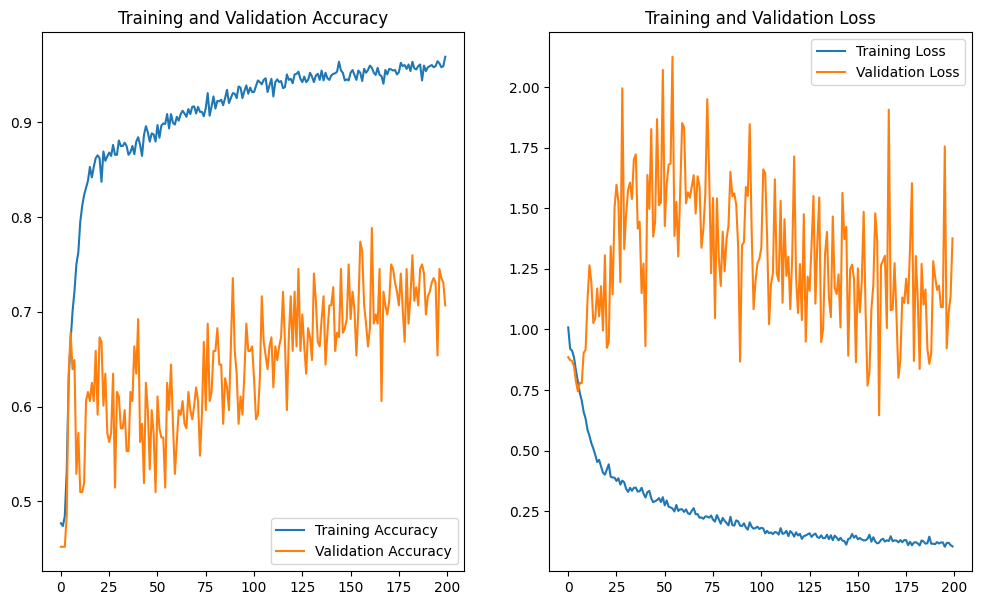

In [ ]:
plt.figure(figsize=(12, 7))
plt.subplot(1, 2, 1)
plt.plot(range(len(train_acc)), train_acc, label='Training Accuracy')
plt.plot(range(len(val_acc)), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(len(train_loss)), train_loss, label='Training Loss')
plt.plot(range(len(val_loss)), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

In [ ]:
# Model at Batch Size 16 and Learning Rate 0.001
input_shape = (Batch_Size, Image_Size, Image_Size, Channels)
model_16_DR4_001 = Sequential([
    resize_and_rescale,
    layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    layers.MaxPool2D((2,2)),

    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(3, activation='softmax')
])
model_16_DR4_001.build(input_shape = input_shape)
model_16_DR4_001.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (16, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (16, 254, 254, 16)        448       
                                                                 
 max_pooling2d (MaxPooling2  (16, 127, 127, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (16, 125, 125, 32)        4640      
                                                                 
 max_pooling2d_1 (MaxPoolin  (16, 62, 62, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (16, 60, 60, 64)         

In [ ]:
learning_rate = 0.001
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model_16_DR4_001.compile(
    optimizer=adam_optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'])

In [ ]:
#Fit the model with training data and also pass validation data
history_16_DR4_001 = model_16_DR4_001.fit(
train_ds, epochs = 200, batch_size = Batch_Size, verbose = 1, validation_data = val_ds)

Epoch 1/200
108/108 [==============================] - 39s 320ms/step - loss: 0.9286 - accuracy: 0.4965 - val_loss: 0.8711 - val_accuracy: 0.4760
Epoch 2/200
108/108 [==============================] - 33s 305ms/step - loss: 0.8189 - accuracy: 0.5802 - val_loss: 0.8893 - val_accuracy: 0.5769
Epoch 3/200
108/108 [==============================] - 34s 314ms/step - loss: 0.7345 - accuracy: 0.6610 - val_loss: 0.6748 - val_accuracy: 0.7212
Epoch 4/200
108/108 [==============================] - 34s 316ms/step - loss: 0.6151 - accuracy: 0.7401 - val_loss: 0.6476 - val_accuracy: 0.7452
Epoch 5/200
108/108 [==============================] - 34s 315ms/step - loss: 0.5039 - accuracy: 0.8099 - val_loss: 0.5162 - val_accuracy: 0.7692
Epoch 6/200
108/108 [==============================] - 34s 316ms/step - loss: 0.4617 - accuracy: 0.8151 - val_loss: 0.3879 - val_accuracy: 0.8029
Epoch 7/200
108/108 [==============================] - 34s 312ms/step - loss: 0.4035 - accuracy: 0.8320 - val_loss: 0.4173 -

In [ ]:
model_path = '/content/drive/My Drive/best_model_16_DR4_001'
loaded_model = tf.keras.models.load_model(model_path)

In [ ]:
scores = loaded_model.evaluate(test_ds)

14/14 [==============================] - 0s 8ms/step - loss: 0.0390 - accuracy: 0.9866


In [ ]:
predictions = loaded_model.predict(test_ds)
predictions

In [ ]:
import numpy as np
predicted_labels = np.argmax(predictions, axis=-1)
# Assuming that each element in test_ds is a (data, label) tuple
true_labels = []
for _, y in test_ds:
    true_labels.extend(y.numpy())

# Convert list to numpy array
true_labels = np.array(true_labels)


In [ ]:
print("Length of true_labels:", len(true_labels))
print("Length of predicted_labels:", len(predicted_labels))


Length of true_labels: 224
Length of predicted_labels: 224


In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_auc_score

# Classification report for precision, recall, f1-score
report = classification_report(true_labels, predicted_labels, target_names=['Potato Healthy', 'Potato Early Blight', 'Potato Late Blight'])
print(report)

# Confusion Matrix
conf_matrix = confusion_matrix(true_labels, predicted_labels)
print(conf_matrix)

# Accuracy
accuracy = accuracy_score(true_labels, predicted_labels)
print(f'Accuracy: {accuracy}')


                     precision    recall  f1-score   support

     Potato Healthy       0.98      1.00      0.99        97
Potato Early Blight       1.00      0.97      0.99       115
 Potato Late Blight       0.92      1.00      0.96        12

           accuracy                           0.99       224
          macro avg       0.97      0.99      0.98       224
       weighted avg       0.99      0.99      0.99       224

[[ 97   0   0]
 [  2 112   1]
 [  0   0  12]]
Accuracy: 0.9866071428571429


In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

# Binarize the true labels
y_binarized = label_binarize(true_labels, classes=[0, 1, 2])

# Calculate AUC-ROC
roc_auc = roc_auc_score(y_binarized, predictions, multi_class='ovr')
print(f'AUC-ROC: {roc_auc}')


AUC-ROC: 1.0


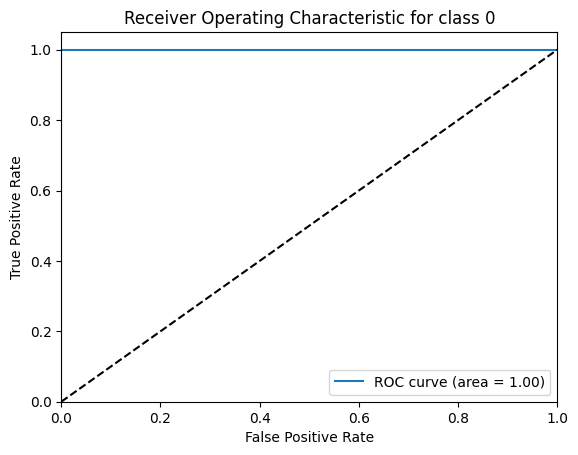

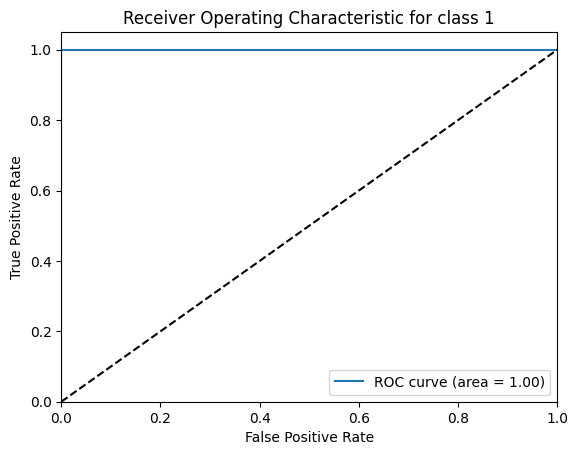

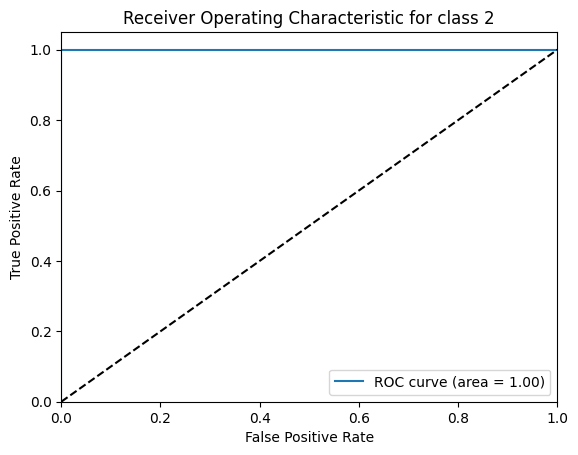

In [ ]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

# Compute ROC curve for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
n_classes = 3

for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_binarized[:, i], predictions[:, i])
    roc_auc[i] = roc_auc_score(y_binarized[:, i], predictions[:, i])

# Plotting
for i in range(n_classes):
    plt.figure()
    plt.plot(fpr[i], tpr[i], label='ROC curve (area = %0.2f)' % roc_auc[i])
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic for class {}'.format(i))
    plt.legend(loc="lower right")
    plt.show()


In [ ]:
# Getting the model history to analyse
train_loss = history_16_DR4_001.history['loss']
train_acc = history_16_DR4_001.history['accuracy']

val_loss = history_16_DR4_001.history['val_loss']
val_acc = history_16_DR4_001.history['val_accuracy']

Text(0.5, 1.0, 'Training and Validation Loss')

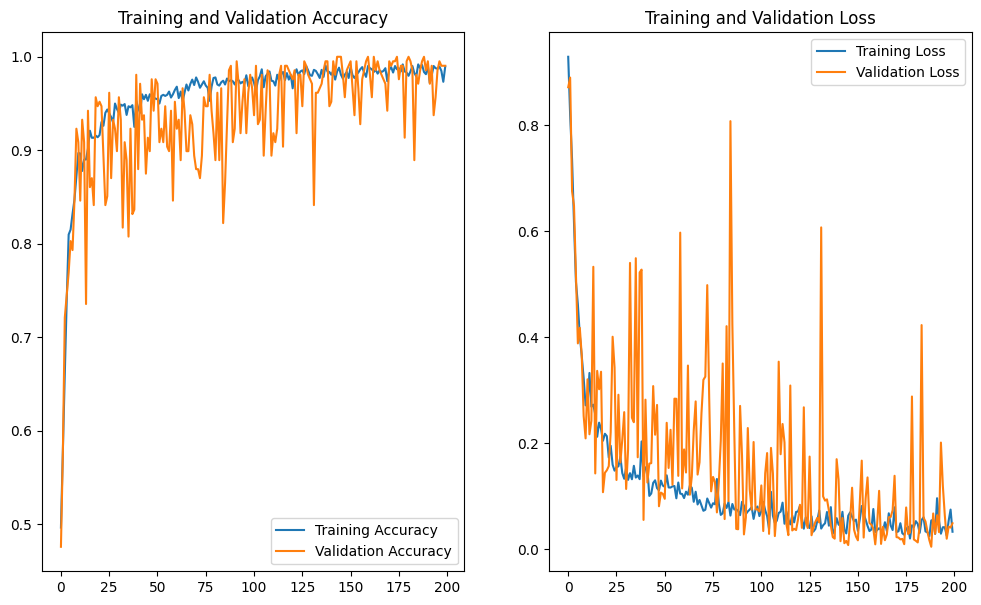

In [ ]:
plt.figure(figsize=(12, 7))
plt.subplot(1, 2, 1)
plt.plot(range(len(train_acc)), train_acc, label='Training Accuracy')
plt.plot(range(len(val_acc)), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(len(train_loss)), train_loss, label='Training Loss')
plt.plot(range(len(val_loss)), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')

In [ ]:
model_16_DR4_001.save('/content/drive/My Drive/best_model_16_DR4_001')

In [ ]:
# Model at Batch Size 16 and Learning Rate 0.01
input_shape = (Batch_Size, Image_Size, Image_Size, Channels)
model16_DR4_01 = Sequential([
    resize_and_rescale,
    layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu', input_shape=input_shape),
    layers.MaxPool2D((2,2)),

    layers.Conv2D(32, (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),

    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPool2D((2,2)),
    layers.GlobalAveragePooling2D(),
    layers.Dense(64, activation='relu'),
    layers.Dropout(0.4),
    layers.Dense(3, activation='softmax')
])
model16_DR4_01.build(input_shape = input_shape)
model16_DR4_01.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (None, 256, 256, 3)       0         
                                                                 
 conv2d_3 (Conv2D)           (16, 254, 254, 16)        448       
                                                                 
 max_pooling2d_3 (MaxPoolin  (16, 127, 127, 16)        0         
 g2D)                                                            
                                                                 
 conv2d_4 (Conv2D)           (16, 125, 125, 32)        4640      
                                                                 
 max_pooling2d_4 (MaxPoolin  (16, 62, 62, 32)          0         
 g2D)                                                            
                                                                 
 conv2d_5 (Conv2D)           (16, 60, 60, 64)         

In [ ]:
learning_rate = 0.01
adam_optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
model16_DR4_01.compile(
    optimizer=adam_optimizer,
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'])

In [ ]:
#Fit the model with training data and also pass validation data
history16_DR4_01 = model16_DR4_01.fit(
train_ds, epochs = 200, batch_size = Batch_Size, verbose = 1, validation_data = val_ds)

Epoch 1/200
108/108 [==============================] - 35s 310ms/step - loss: 0.9202 - accuracy: 0.4576 - val_loss: 0.9877 - val_accuracy: 0.3317
Epoch 2/200
108/108 [==============================] - 33s 309ms/step - loss: 0.9070 - accuracy: 0.4535 - val_loss: 0.9419 - val_accuracy: 0.5673
Epoch 3/200
108/108 [==============================] - 33s 308ms/step - loss: 0.9042 - accuracy: 0.4651 - val_loss: 0.9528 - val_accuracy: 0.5673
Epoch 4/200
108/108 [==============================] - 33s 309ms/step - loss: 0.9014 - accuracy: 0.4570 - val_loss: 0.9484 - val_accuracy: 0.5673
Epoch 5/200
108/108 [==============================] - 33s 309ms/step - loss: 0.9010 - accuracy: 0.4756 - val_loss: 0.9630 - val_accuracy: 0.3317
Epoch 6/200
108/108 [==============================] - 33s 308ms/step - loss: 0.8995 - accuracy: 0.4715 - val_loss: 0.9732 - val_accuracy: 0.3317
Epoch 7/200
108/108 [==============================] - 33s 307ms/step - loss: 0.8978 - accuracy: 0.4878 - val_loss: 1.0021 -

In [ ]:
# Getting the model history to analyse
train_loss = history16_DR4_01.history['loss']
train_acc = history16_DR4_01.history['accuracy']

val_loss = history16_DR4_01.history['val_loss']
val_acc = history16_DR4_01.history['val_accuracy']

Text(0.5, 1.0, 'Training and Validation Loss')

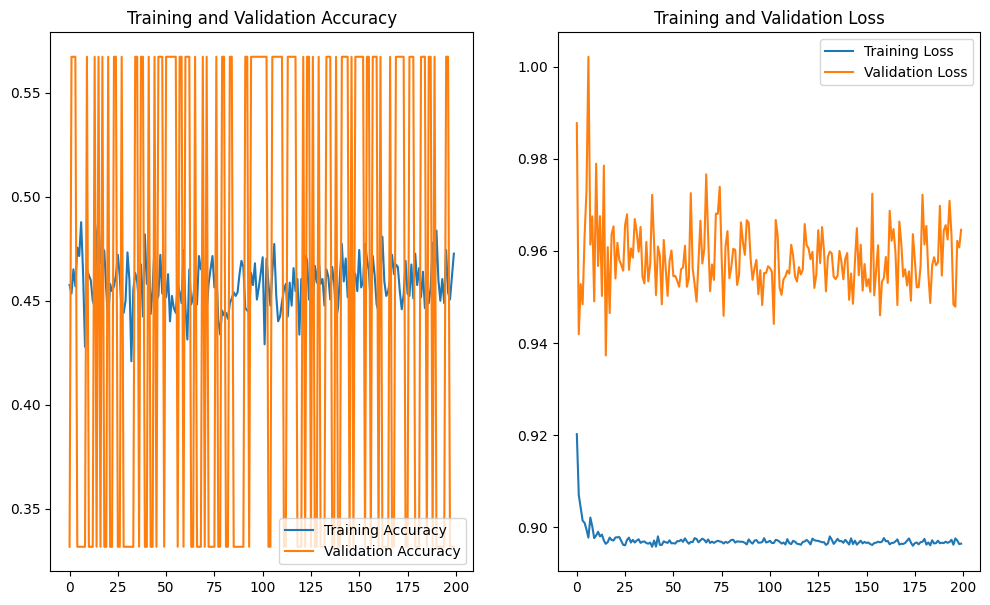

In [ ]:
plt.figure(figsize=(12, 7))
plt.subplot(1, 2, 1)
plt.plot(range(len(train_acc)), train_acc, label='Training Accuracy')
plt.plot(range(len(val_acc)), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(len(train_loss)), train_loss, label='Training Loss')
plt.plot(range(len(val_loss)), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')